In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log, square, sqrt, power, arange, ones, zeros, isscalar,\
    array, outer, pi, sin, cos, expand_dims, repeat, full, concatenate, ravel
from numpy.random import normal
from scipy.optimize import least_squares, minimize
%matplotlib inline

In [228]:
# Trade data

stock_name = 'MSFT.O'
#NSQ_OneYear100closeA_Sept21.csv
df = pd.read_csv('NSQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
apple = df[df['RIC'] == stock_name]
apple['Date'] = pd.to_datetime(apple['Local_Date_Time']).dt.date

qqq = pd.read_csv('QQQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
qqq['Date'] = pd.to_datetime(qqq['Local_Date_Time']).dt.date

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [229]:
# Auction price data
auction = pd.read_csv('NSQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
apple_auction = auction[auction['RIC'] == stock_name]
apple_auction['Date'] = pd.to_datetime(apple_auction['Local_Date_Time']).dt.date

auction_qqq = pd.read_csv('QQQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
auction_qqq['Date'] = pd.to_datetime(auction_qqq['Local_Date_Time']).dt.date

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Model 1A

Question 1A: How well does $\sigma_{t}^{2}$ forecast $\sigma_{t+1}^{2}$ ? Is it biased?

In [230]:
# Data Processing (10 minute intervals)

dates = apple['Date'].unique()
dates_final = []
stocks = []
daily_return = []
auction_log_returns = []
auction_log_returns_340350 = []
daily_volatility = []
daily_volatility_minus4pm = []
avg_20day_volatility = []

for date in dates:
    
    apple_today = apple[apple['Date'] == date]
    apple_auction_today = apple_auction[apple_auction['Date'] == date]
    apple_today = apple_today.set_index(pd.DatetimeIndex(apple_today['Local_Date_Time']))
    apple_today_10min_max = pd.DataFrame(apple_today['High'].resample("10T").max())
    apple_today_10min_min = pd.DataFrame(apple_today['Low'].resample("10T").min())
    apple_today_10min_open = pd.DataFrame(apple_today['Open'].resample("10T").first())
    apple_today_10min_close = pd.DataFrame(apple_today['Close'].resample("10T").last())
    apple_today_10min = apple_today_10min_max.join(apple_today_10min_min)
    apple_today_10min = apple_today_10min.join(apple_today_10min_open)
    apple_today_10min = apple_today_10min.join(apple_today_10min_close)
    
    # Garman and Klass Volatility formula
    apple_today_10min['Volatility'] = np.sqrt(0.5*np.square(np.log(apple_today_10min['High']/apple_today_10min['Low'])) - (2*np.log(2)-1)*np.square(np.log(apple_today_10min['Close']/apple_today_10min['Open'])))
#     apple_today_10min['log_returns'] = abs(np.log(apple_today_10min['Close']/apple_today_10min['Open'])) # alternate volatility formula
    
    volatility_today = [val for val in apple_today_10min['Volatility'].values]
    return_today = (apple_today_10min['Close']/apple_today_10min['Open']).values
    
    if len(volatility_today) != 39: # Skip if there are fewer than 390 minutes of trading data
        continue
        
    # Dates for which the trade data is complete
    dates_final.append(date)
    
    # Change the 39th 10min interval to include the auction price (instead of close)
    auction_volatility = np.sqrt(0.5*np.square(np.log(apple_today_10min['High'][-1]/apple_today_10min['Low'][-1])) - (2*np.log(2)-1)*np.square(np.log(apple_auction_today['Price'].iloc[0]/apple_today_10min['Open'][-1])))
    volatility_today[-1] = auction_volatility
    
    # 10 minute interval volatility * number of complete trade days
    stocks.append(volatility_today)
    
    # Daily raw return
    daily_return.append(return_today)
        
    # Auction Volatility Information
    auction_log_returns_today = abs(np.log(apple_auction_today['Price'].iloc[0]/apple_today_10min['Open'][-1]))
    auction_log_returns.append(auction_log_returns_today)
    
    # Naive Auction Volatility Estimate (Volatility between 3:40pm and 3:50pm)
    auction_log_returns_today_340350 = abs(np.log(apple_today_10min['Open'][-1]/apple_today_10min['Open'][-2]))
    auction_log_returns_340350.append(auction_log_returns_today_340350)
    
    # Average daily volatility (later used for EWMA 20Day)
    daily_volatility.append(sum(volatility_today))
    daily_volatility_minus4pm.append(sum(volatility_today[:-1]))

daily_return = np.array(daily_return)
volatility_df = pd.DataFrame({'Date':dates_final, 'daily_volatility': daily_volatility, 'daily_volatility_minus4pm': daily_volatility_minus4pm})
volatility_df['volatility_ewma20'] = np.array([None] + [i for i in volatility_df['daily_volatility'].ewm(span=20).mean()][:-1])

stocks = stocks[20:]
stocks = np.vstack(stocks).T # Training data for Anderson model
avg_20day_volatility_raw = np.array(volatility_df['volatility_ewma20'])
avg_20day_volatility = np.array(volatility_df['volatility_ewma20'][20:]) # Sigma_t input for Anderson model


In [231]:
df_mod1A = pd.DataFrame()
r1 = volatility_df['Date'].values
df_mod1A['Date'] = r1[20:]
df_mod1A['Actual Volatility'] = daily_volatility[20:]
df_mod1A['Predicted Volatility'] = avg_20day_volatility_raw[20:] # span=20 EWMA up to t-1

In [232]:
df_mod1A

,Date,Actual Volatility,Predicted Volatility
0,2020-09-30,0.088772,0.103816
1,2020-10-01,0.077314,0.102183
2,2020-10-02,0.095458,0.09952
3,2020-10-05,0.047998,0.09909
4,2020-10-06,0.089049,0.09374
...,...,...,...
226,2021-08-26,0.039340,0.045074
227,2021-08-27,0.040844,0.044528
228,2021-08-30,0.037412,0.044177
229,2021-08-31,0.038066,0.043533


In [233]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(mean_absolute_error(df_mod1A['Actual Volatility'][-211:], df_mod1A['Predicted Volatility'][-211:]))
print(mean_squared_error(df_mod1A['Actual Volatility'][-211:], df_mod1A['Predicted Volatility'][-211:]))
print(r2_score(df_mod1A['Actual Volatility'][-211:], df_mod1A['Predicted Volatility'][-211:]))

0.0135350492578639
0.0003258929382127227
0.3412783324820632


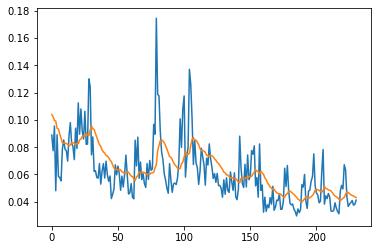

In [234]:
plt.plot(df_mod1A['Actual Volatility'])
plt.plot(df_mod1A['Predicted Volatility'])

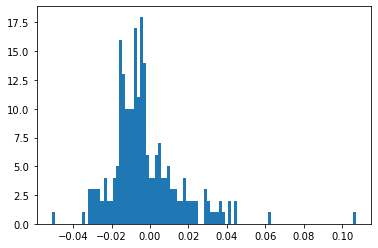

In [235]:
plt.hist(df_mod1A['Actual Volatility'] - df_mod1A['Predicted Volatility'], bins=100)
plt.show()

### Model 1B

Question 1B: How well does $\sigma_{t,B}^{2}$ forecast $\sigma_{t+1,B}^{2}$ ? Is it biased?

In [247]:
volatility_df['auction'] = volatility_df['daily_volatility'] - volatility_df['daily_volatility_minus4pm']
volatility_df['volatility_ewma20_minus4pm'] = np.array([None] + [i for i in volatility_df['daily_volatility_minus4pm'].ewm(span=20).mean()][:-1])
volatility_df['volatility_ewma20_auction'] = np.array([None] + [i for i in volatility_df['auction'].ewm(span=20).mean()][:-1])
volatility_df

,Date,daily_volatility,daily_volatility_minus4pm,volatility_ewma20,auction,volatility_ewma20_auction,daily_volatility_minus4pm_yest,volatility_ewma20_auction_1c,volatility_ewma20_minus4pm
0,2020-09-01,0.070265,0.067671,None,0.002594,None,NaN,NaN,None
1,2020-09-02,0.100873,0.098039,0.070265,0.002834,0.002594,0.067671,0.003759,0.067671
2,2020-09-03,0.173458,0.164862,0.086334,0.008596,0.00272,0.098039,0.004574,0.083614
3,2020-09-04,0.237680,0.232795,0.118326,0.004885,0.004878,0.164862,0.006888,0.113448
4,2020-09-08,0.153812,0.149448,0.152781,0.004364,0.00488,0.232795,0.003133,0.147902
...,...,...,...,...,...,...,...,...,...
246,2021-08-26,0.039340,0.037776,0.045074,0.001563,0.00149,0.037100,0.001517,0.043584
247,2021-08-27,0.040844,0.039283,0.044528,0.001561,0.001497,0.037776,0.001557,0.043031
248,2021-08-30,0.037412,0.036178,0.044177,0.001234,0.001503,0.039283,0.001384,0.042674
249,2021-08-31,0.038066,0.034968,0.043533,0.003098,0.001477,0.036178,0.001428,0.042055


In [248]:
df_mod1B = pd.DataFrame()
df_mod1B['Date'] = volatility_df['Date'][20:]
df_mod1B['Actual Volatility'] = volatility_df['auction'][20:]
df_mod1B['Predicted Volatility'] = volatility_df['volatility_ewma20_auction'][20:]

In [249]:
df_mod1B

,Date,Actual Volatility,Predicted Volatility
20,2020-09-30,0.004056,0.003529
21,2020-10-01,0.002168,0.003586
22,2020-10-02,0.003133,0.003434
23,2020-10-05,0.001451,0.003402
24,2020-10-06,0.004327,0.003198
...,...,...,...
246,2021-08-26,0.001563,0.00149
247,2021-08-27,0.001561,0.001497
248,2021-08-30,0.001234,0.001503
249,2021-08-31,0.003098,0.001477


In [250]:
print(mean_absolute_error(df_mod1B['Actual Volatility'][-211:], df_mod1B['Predicted Volatility'][-211:]))
print(mean_squared_error(df_mod1B['Actual Volatility'][-211:], df_mod1B['Predicted Volatility'][-211:]))
print(r2_score(df_mod1B['Actual Volatility'][-211:], df_mod1B['Predicted Volatility'][-211:]))

0.0008432325974463128
1.2705192340659731e-06
0.2119040511941237


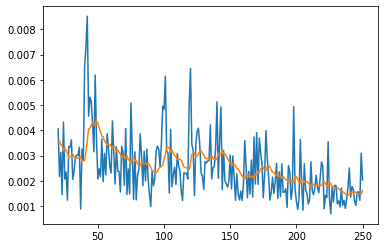

In [251]:
plt.plot(df_mod1B['Actual Volatility'])
plt.plot(df_mod1B['Predicted Volatility'])

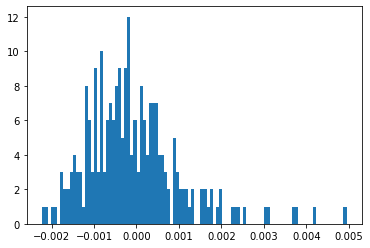

In [252]:
plt.hist(df_mod1B['Actual Volatility'] - df_mod1B['Predicted Volatility'], bins=100)
plt.show()

### Model 1C

Question 1C: How well does $\gamma\sigma_{t}^{2}$, where $\gamma = \dfrac{\sigma_{t+1,A}^{2}}{\sigma_{t,A}^{2}}$ forecast $\sigma_{t+1,B}^{2}$ ? Is it biased? \
(A corresponds to 9:30:00 to 15:49:59\
B corresponds to 15:50:00 to 16:00:00)

In [254]:
volatility_df['volatility_ewma20_minus4pm_yest'] = volatility_df['volatility_ewma20_minus4pm'].shift(1)
volatility_df['volatility_ewma20_auction_1c'] = volatility_df['daily_volatility_minus4pm']/volatility_df['volatility_ewma20_minus4pm_yest']*volatility_df['volatility_ewma20_auction']


In [255]:
df_mod1C = pd.DataFrame()
df_mod1C['Date'] = volatility_df['Date'][20:]
df_mod1C['Actual Volatility'] = volatility_df['auction'][20:]
df_mod1C['Predicted Volatility'] = volatility_df['volatility_ewma20_auction_1c'][20:]

In [256]:
print(mean_absolute_error(df_mod1C['Actual Volatility'][-211:], df_mod1C['Predicted Volatility'][-211:]))
print(mean_squared_error(df_mod1C['Actual Volatility'][-211:], df_mod1C['Predicted Volatility'][-211:]))
print(r2_score(df_mod1C['Actual Volatility'][-211:], df_mod1C['Predicted Volatility'][-211:]))

0.000779948170270515
1.0810582500684706e-06
0.3294256360247343


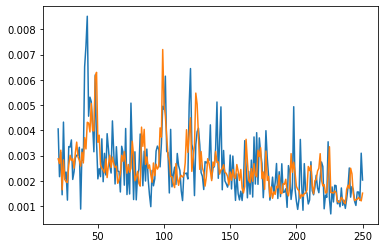

In [257]:
plt.plot(df_mod1C['Actual Volatility'])
plt.plot(df_mod1C['Predicted Volatility'])

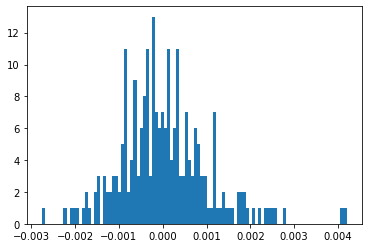

In [258]:
plt.hist(df_mod1C['Actual Volatility'] - df_mod1C['Predicted Volatility'], bins=100)
plt.show()